<a href="https://colab.research.google.com/github/italoEng/TCC/blob/main/TCC_PREVIS%C3%83O_DE_GERA%C3%87%C3%83O_DE_ENERGIA_EM_USINAS_SOLARES_USANDO_REDES_NEURAIS_ARTIFICIAIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (15, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
# arquivo
dataset_path = "/content/TCC2_Aracau_2015_a_2020.csv"

In [3]:
#importa para dataframe
df = pd.read_csv(dataset_path)

#ler tabela
df.head()


,Data Medicao,Hora Medicao,RADIACAO GLOBAL(Kj/m²),TEMPERATURA DO AR - BULBO SECO HORARIA(°C),TEMPERATURA DO AR - BULBO SECO HORARIA(°C).1,VENTO RAJADA MAXIMA(m/s)
0,1/1/2015,0:00:00,NaN,25.2,80.0,5.0
1,1/1/2015,1:00:00,NaN,24.5,84.0,3.7
2,1/1/2015,2:00:00,NaN,24.2,86.0,3.4
3,1/1/2015,3:00:00,NaN,24.0,86.0,3.3
4,1/1/2015,4:00:00,NaN,23.5,88.0,2.9


In [4]:
# tipos dos dados
df.dtypes

Data Medicao                                     object
Hora Medicao                                     object
RADIACAO GLOBAL(Kj/m²)                          float64
TEMPERATURA DO AR - BULBO SECO HORARIA(°C)      float64
TEMPERATURA DO AR - BULBO SECO HORARIA(°C).1    float64
VENTO  RAJADA MAXIMA(m/s)                       float64
dtype: object

In [5]:
# Mudar o nome das colunas
df.columns = ['DATA','HORA','RADIACAO','TEMPERATURA','UMIDADE','VENTO']
df.head()

,DATA,HORA,RADIACAO,TEMPERATURA,UMIDADE,VENTO
0,1/1/2015,0:00:00,NaN,25.2,80.0,5.0
1,1/1/2015,1:00:00,NaN,24.5,84.0,3.7
2,1/1/2015,2:00:00,NaN,24.2,86.0,3.4
3,1/1/2015,3:00:00,NaN,24.0,86.0,3.3
4,1/1/2015,4:00:00,NaN,23.5,88.0,2.9


In [6]:
# unir coluna Data com Hora 
df["DATAHORA"] = df["DATA"] + " " + df["HORA"]

In [7]:
# Mudando a coluna DATAHORA para o formato datetime64
df["DATAHORA"] = pd.to_datetime(df["DATAHORA"], format= "%m/%d/%Y %H:%M:%S", errors="ignore")

In [8]:
# Excluindo as colunas DATA e HORA
df.drop("DATA", axis=1, inplace=True)
df.drop("HORA", axis=1, inplace=True)

In [9]:
# Excluindo linha com dados faltantes
df.dropna(axis=0, inplace=True)

In [10]:
# Excluir numerios negativos
indexesProblematicos = df[df["RADIACAO"] < 0].index
df.drop(indexesProblematicos, inplace=True)

In [11]:
# mostra o número de dados faltantes no data frame
df.isna().sum()

RADIACAO       0
TEMPERATURA    0
UMIDADE        0
VENTO          0
DATAHORA       0
dtype: int64

In [12]:
# tipos dos dados
df.dtypes

RADIACAO              float64
TEMPERATURA           float64
UMIDADE               float64
VENTO                 float64
DATAHORA       datetime64[ns]
dtype: object

In [13]:
# Estatísticas descrititivas do conjunto de dados

# describe : gera estatisticas descritivas
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
RADIACAO,21190.0,1355.583709,1116.567079,0.016,282.82025,1194.0425,2330.542,5218.616
TEMPERATURA,21190.0,28.716819,3.072182,20.300,26.40000,28.8000,31.200,37.000
UMIDADE,21190.0,68.663426,18.440437,20.000,53.00000,68.0000,85.000,100.000
VENTO,21190.0,7.268235,3.701361,0.100,4.30000,7.9000,10.300,18.000


In [14]:
# Transformando a coluna DATAHORA em index 
df.set_index("DATAHORA", inplace= True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f74288e42d0>,
      dtype=object)

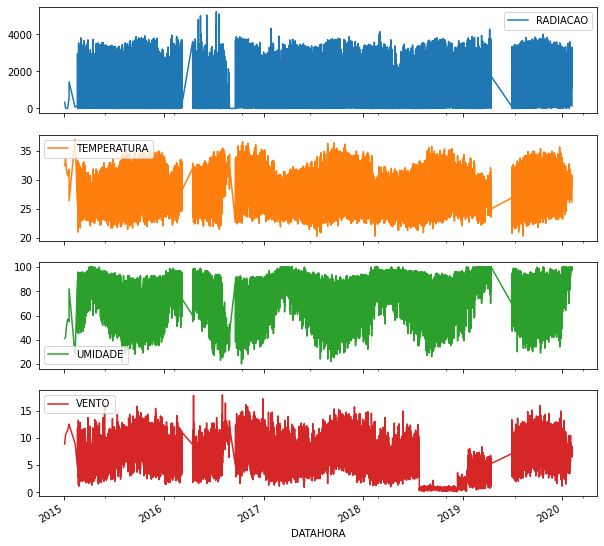

In [15]:
# plot dos dados no tempo
df.plot(figsize=(10, 10), subplots=True)

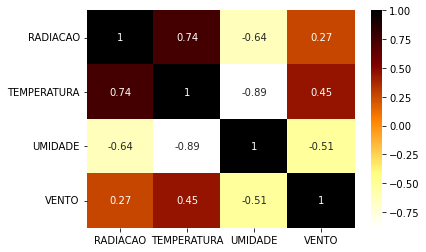

In [16]:
# correlação entre os dados climaticos
sns.heatmap(df.corr(), annot = True, cmap="afmhot_r")



In [17]:
df.corr()

,RADIACAO,TEMPERATURA,UMIDADE,VENTO
RADIACAO,1.000000,0.744773,-0.635620,0.266686
TEMPERATURA,0.744773,1.000000,-0.887413,0.449606
UMIDADE,-0.635620,-0.887413,1.000000,-0.513829
VENTO,0.266686,0.449606,-0.513829,1.000000


# Divisão de Dados

In [18]:
# Divisão dos dados não aleatoriamente
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df) # conta todos os dados para poder fazer a divição 
train_df = df[0:int(n*0.7)] # treinamento 70%
val_df = df[int(n*0.7):int(n*0.9)] # validação 20%
test_df = df[int(n*0.9):] # teste 10%

num_features = df.shape[1] # (6348,4) quantidade de colunas que possui o data frame, que e 4

# Normalização de Dados

In [19]:
# Normalização de dados

train_mean = train_df.mean() # media dos dados de treinamento
train_std = train_df.std() # devio padrão dos dados de treinamento

# normalização dos dados
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

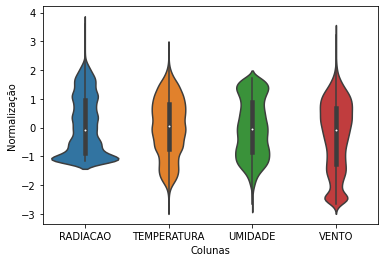

In [20]:
# Gráfico de violino
df_std = (df - train_mean) / train_std # calculo do desvio
df_std = df_std.melt(var_name='Colunas', value_name='Normalização') # indetificação dos eixos do gráfico
df_violi = sns.violinplot(x='Colunas', y='Normalização', data=df_std) # cria o gráfico de violino

# Índices e compensações

In [21]:
# janela de dados
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):

    # dados de treinamento, validação e teste
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Calculo das colunas 
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Parametros de tempo escolhidos
    self.input_width = input_width # tamanho da entrada
    self.label_width = label_width # número de previsão que sera feita por janela
    self.shift = shift # tamanho da previsão

    self.total_window_size = input_width + shift # somando o tamanho da entrada com o tamanho da privisão

    self.input_slice = slice(0, input_width) 
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
  def __repr__(self):
    # ultiliza o .join para pular de linha \n
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [22]:
# Fazer um modelo de previsão de 24h no futuro dando 24h de historico

w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=["RADIACAO"])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['RADIACAO']

In [23]:
# Fazer um modelo de previsão de 1mês no futuro dando 1mês de historico
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['RADIACAO'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['RADIACAO']

# Dividir

# 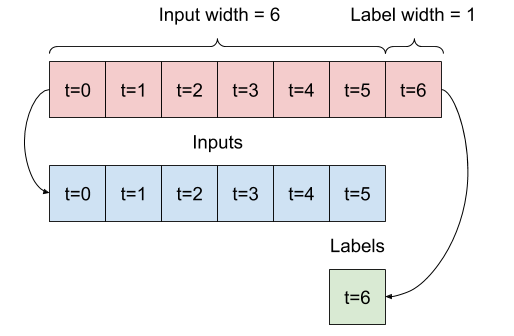

In [24]:
# dividir em janela de entrada e janela de rótulo

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack( [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)


  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [25]:
# Empilhar
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 4)
Inputs shape: (3, 6, 4)
Labels shape: (3, 1, 1)


# Plotagem

In [26]:
w2.example = example_inputs, example_labels

In [27]:
def plot(self, model=None, plot_col='RADIACAO', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#3c0ec4', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#cc2921', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

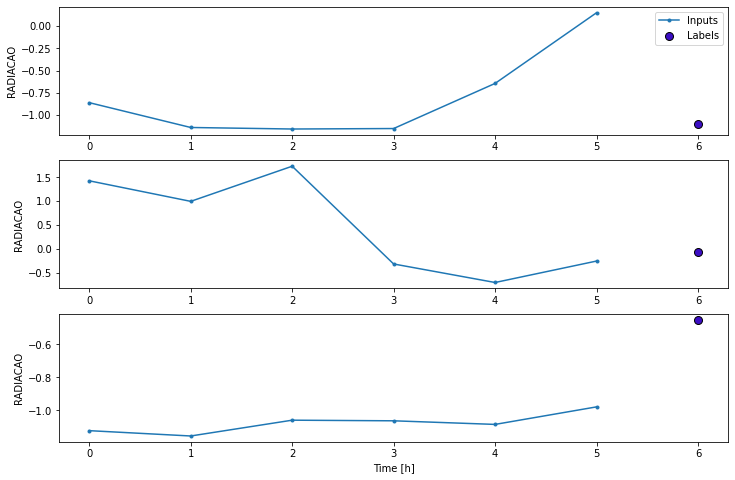

In [28]:
w2.plot()

# Criar tf.data.Dataset

In [29]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [30]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [31]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [32]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 4)
Labels shape (batch, time, features): (32, 1, 1)


# Modelos de etapa única

In [33]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['RADIACAO'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['RADIACAO']

In [34]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 4)
Labels shape (batch, time, features): (32, 1, 1)


# Linha de base

In [35]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [36]:
baseline = Baseline(label_index=column_indices['RADIACAO'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

133/133 [==============================] - 1s 3ms/step - loss: 0.3565 - mean_absolute_error: 0.4673


In [37]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['RADIACAO'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['RADIACAO']

In [38]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 4)
Output shape: (32, 24, 1)


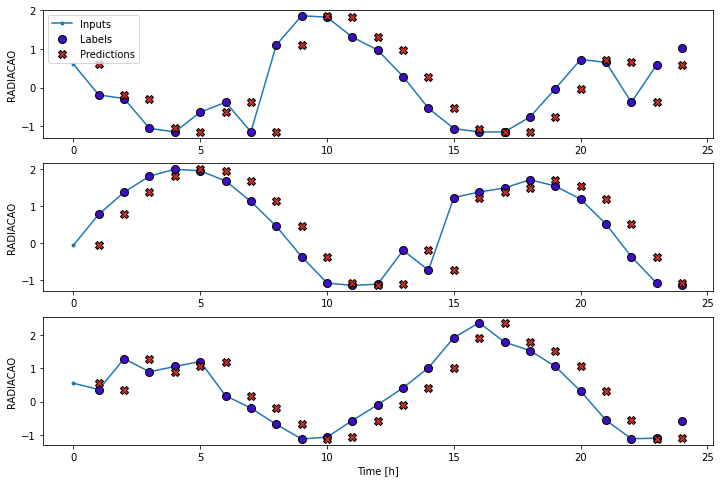

In [39]:
wide_window.plot(baseline)

# Modelo linear

In [40]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [41]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 4)
Output shape: (32, 1, 1)


In [42]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [43]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
464/464 [==============================] - 3s 5ms/step - loss: 1.8060 - mean_absolute_error: 1.0809 - val_loss: 0.7197 - val_mean_absolute_error: 0.6674
Epoch 2/20
464/464 [==============================] - 2s 5ms/step - loss: 0.5933 - mean_absolute_error: 0.5865 - val_loss: 0.4102 - val_mean_absolute_error: 0.4881
Epoch 3/20
464/464 [==============================] - 2s 5ms/step - loss: 0.4348 - mean_absolute_error: 0.4936 - val_loss: 0.3741 - val_mean_absolute_error: 0.4723
Epoch 4/20
464/464 [==============================] - 2s 5ms/step - loss: 0.3860 - mean_absolute_error: 0.4716 - val_loss: 0.3555 - val_mean_absolute_error: 0.4657
Epoch 5/20
464/464 [==============================] - 3s 6ms/step - loss: 0.3647 - mean_absolute_error: 0.4659 - val_loss: 0.3355 - val_mean_absolute_error: 0.4574
Epoch 6/20
464/464 [==============================] - 2s 5ms/step - loss: 0.3548 - mean_absolute_error: 0.4645 - val_loss: 0.3214 - val_mean_absolute_error: 0.4543
Epoch 7/20
464/4

In [44]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 4)
Output shape: (32, 24, 1)


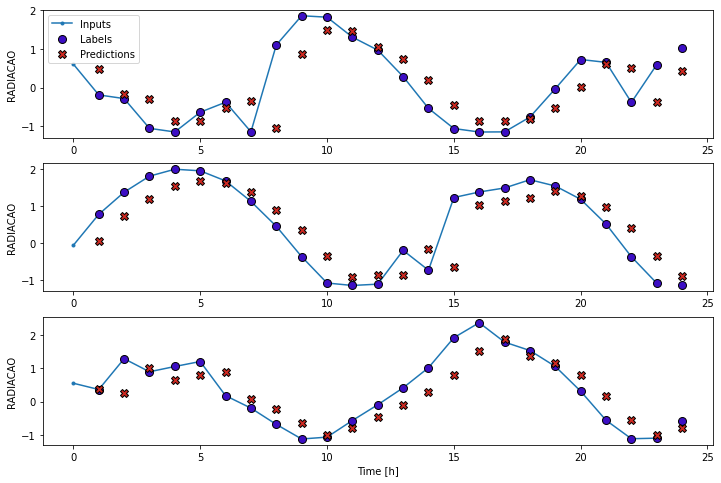

In [45]:
wide_window.plot(linear)

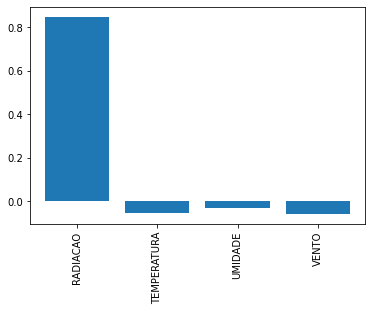

In [46]:
# Visualizar o pesso atribuido a cada camada
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

# Denso

In [47]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
464/464 [==============================] - 3s 6ms/step - loss: 0.3517 - mean_absolute_error: 0.4647 - val_loss: 0.3639 - val_mean_absolute_error: 0.4914
Epoch 2/20
464/464 [==============================] - 3s 5ms/step - loss: 0.3197 - mean_absolute_error: 0.4344 - val_loss: 0.3103 - val_mean_absolute_error: 0.4477
Epoch 3/20
464/464 [==============================] - 3s 5ms/step - loss: 0.3144 - mean_absolute_error: 0.4284 - val_loss: 0.3196 - val_mean_absolute_error: 0.4522
Epoch 4/20
133/133 [==============================] - 1s 4ms/step - loss: 0.3171 - mean_absolute_error: 0.4526


# Multi-step densa

In [48]:
CONV_WIDTH = 24 # horas de entrada
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['RADIACAO'])

conv_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['RADIACAO']

Text(0.5, 1.0, 'Given 24 hours of inputs, predict 1 hour into the future.')

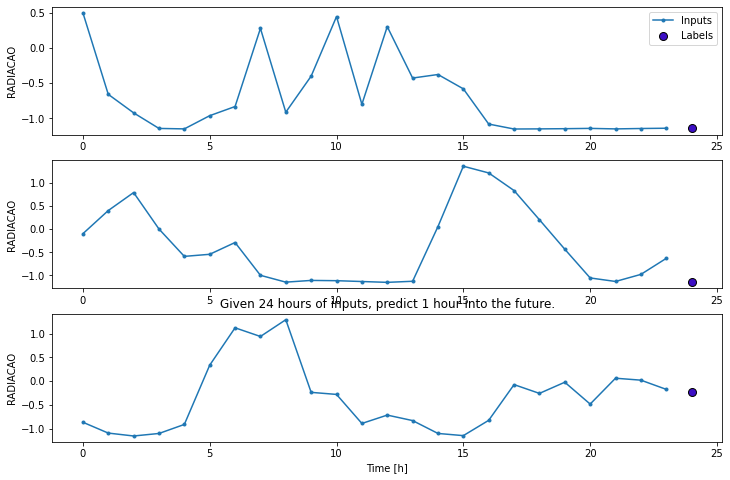

In [49]:
conv_window.plot()
plt.title("Given 24 hours of inputs, predict 1 hour into the future.")

# Rede neural de convolução

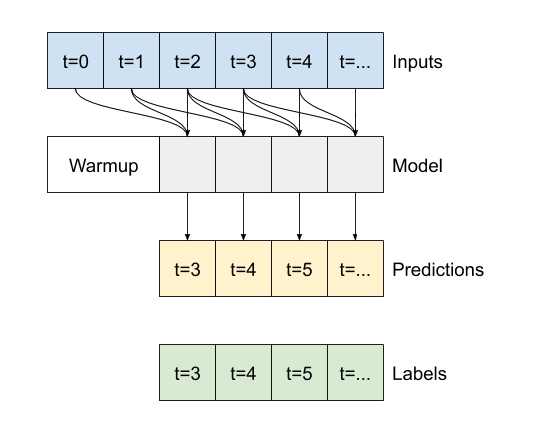

In [50]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [51]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 24, 4)
Output shape: (32, 1, 1)


In [52]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

132/132 [==============================] - 1s 4ms/step - loss: 0.2967 - mean_absolute_error: 0.3946


In [53]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 4)
Labels shape: (32, 24, 1)
Output shape: (32, 1, 1)


In [54]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['RADIACAO'])

wide_conv_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['RADIACAO']

In [55]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 47, 4)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


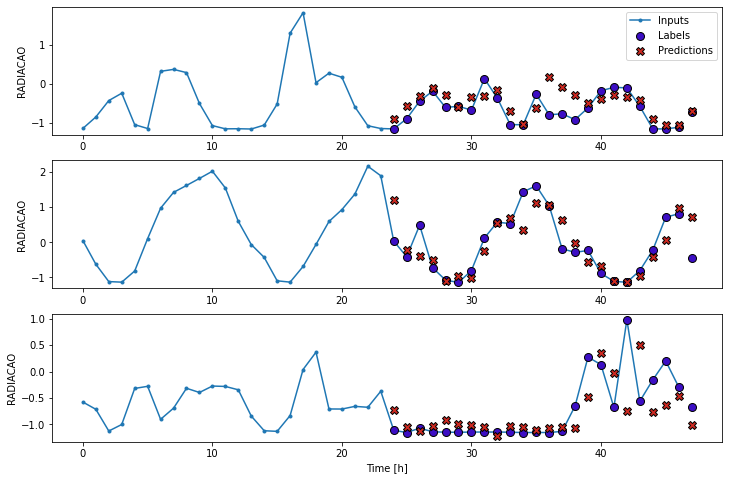

In [56]:
wide_conv_window.plot(conv_model)

# Rede neural recorrente

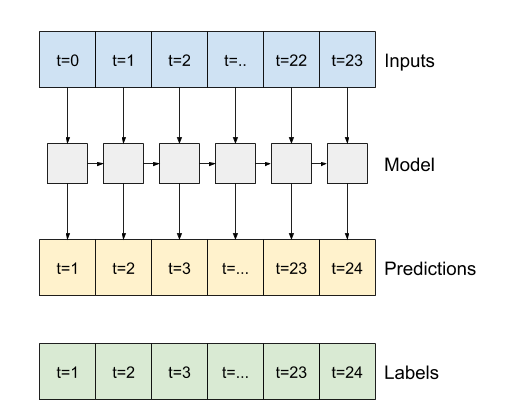

In [57]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [58]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 4)
Output shape: (32, 24, 1)


In [59]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

132/132 [==============================] - 1s 6ms/step - loss: 0.2637 - mean_absolute_error: 0.3805


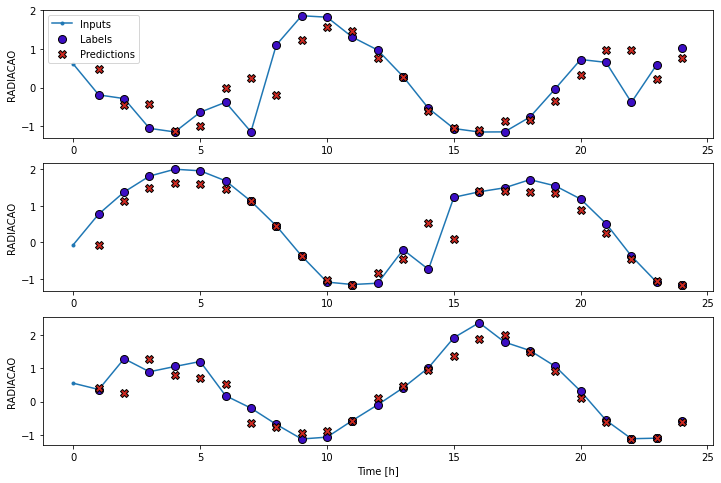

In [60]:

wide_window.plot(lstm_model)


# Desempenho

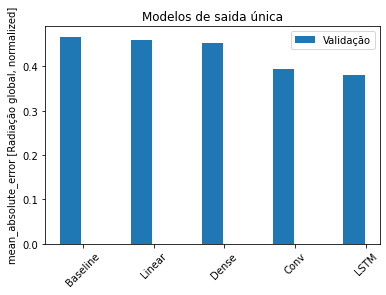

In [61]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.title('Modelos de saida única')
plt.ylabel('mean_absolute_error [Radiação global, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validação')
#plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [62]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.4956
Linear      : 0.4633
Dense       : 0.4002
Conv        : 0.2333
LSTM        : 0.2520


# Modelos multi-etapas

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

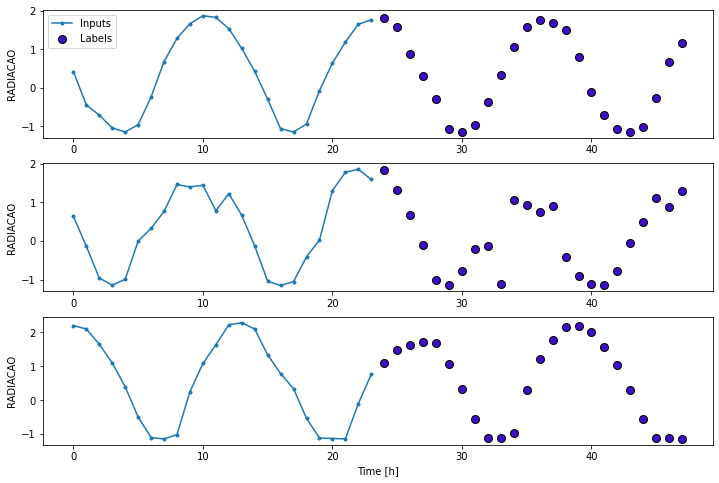

In [63]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

# Baselines

131/131 [==============================] - 1s 4ms/step - loss: 1.3087 - mean_absolute_error: 0.8437


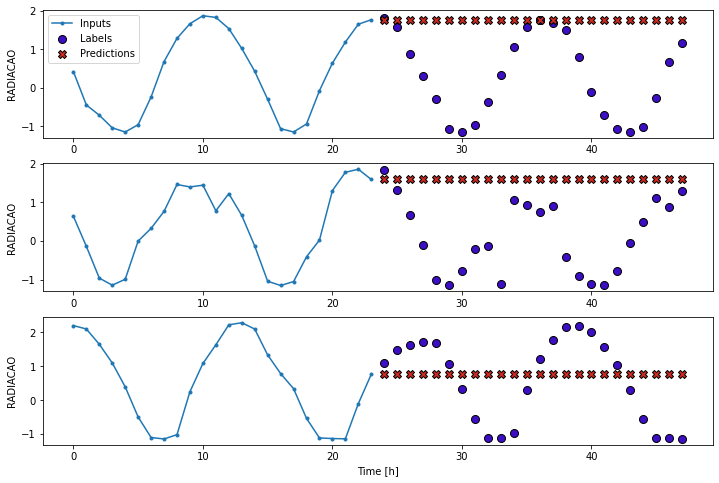

In [64]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Baseline'] = last_baseline.evaluate(multi_window.val)
multi_performance['Baseline'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

#Modelos de disparo único

131/131 [==============================] - 1s 4ms/step - loss: 1.1740 - mean_absolute_error: 0.8813


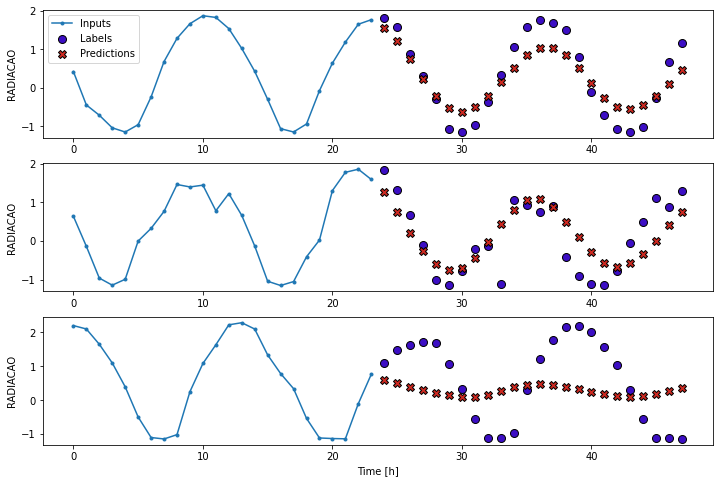

In [65]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

131/131 [==============================] - 1s 4ms/step - loss: 0.9779 - mean_absolute_error: 0.8034


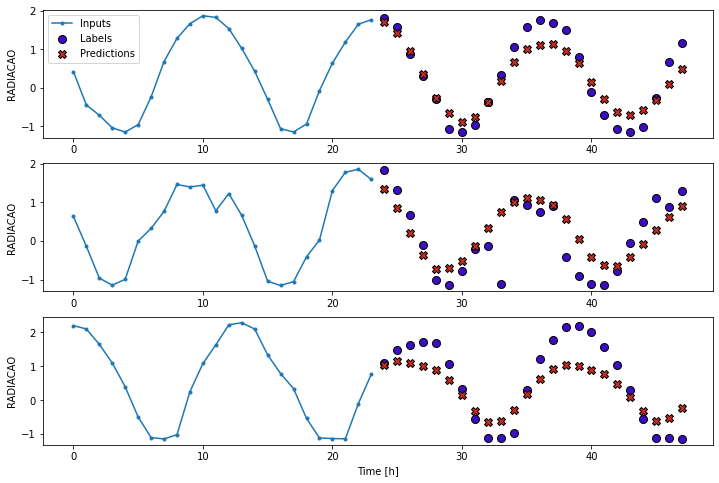

In [66]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

131/131 [==============================] - 1s 4ms/step - loss: 0.8438 - mean_absolute_error: 0.7341


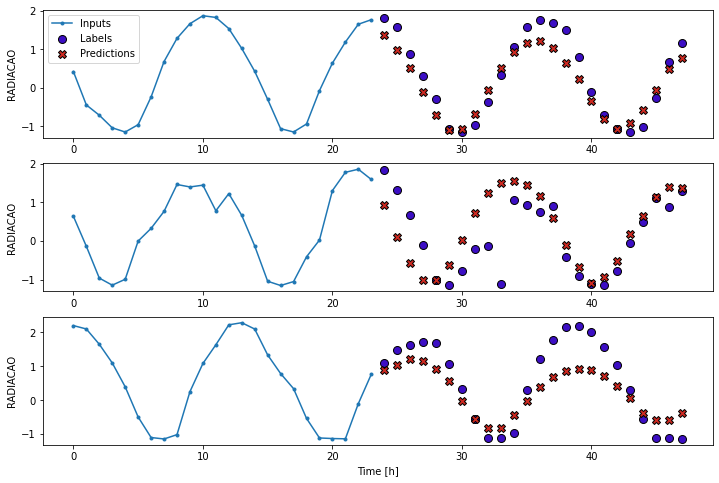

In [67]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

131/131 [==============================] - 1s 6ms/step - loss: 0.8681 - mean_absolute_error: 0.6994


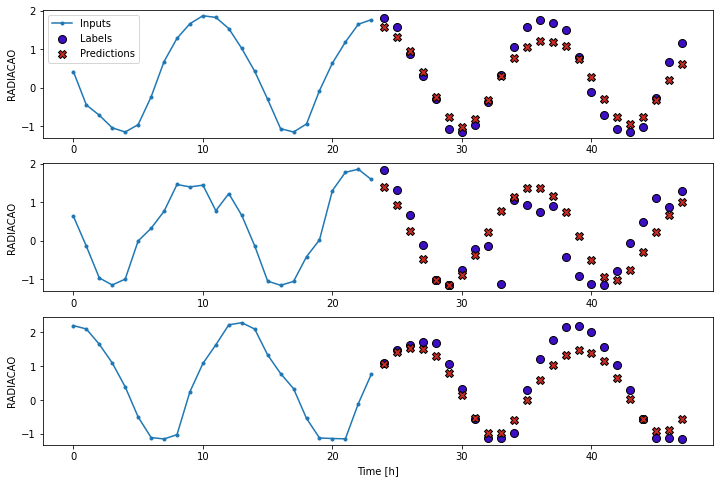

In [68]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

#Avançado: modelo autorregressivo

In [69]:

class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)


#Desempenho

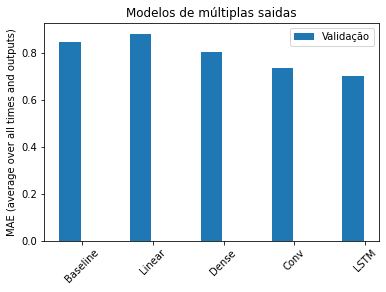

In [70]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.title('Modelos de múltiplas saidas')
plt.bar(x - 0.17, val_mae, width, label='Validação')
#plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [71]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Baseline: 0.9999
Linear  : 0.6978
Dense   : 0.6081
Conv    : 0.4523
LSTM    : 0.3837


In [72]:
multi_performance

{'Baseline': [1.6162389516830444, 0.999872088432312],
 'Conv': [0.3511248528957367, 0.45231127738952637],
 'Dense': [0.5799142122268677, 0.6080697178840637],
 'LSTM': [0.26821476221084595, 0.383716881275177],
 'Linear': [0.7178456783294678, 0.6977991461753845]}

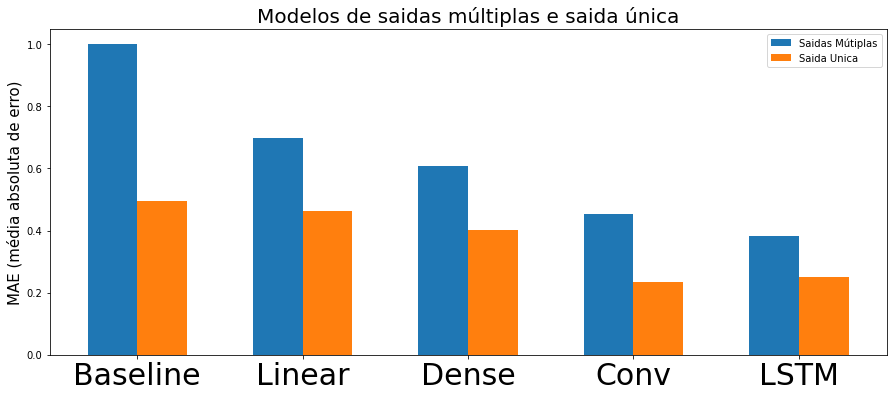

In [75]:
multi_saida = np.arange(len(multi_performance))
unica_saida = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'

metric_index1 = lstm_model.metrics_names.index('mean_absolute_error')
test_mae1 = [v[metric_index] for v in multi_performance.values()]

metric_index2 = lstm_model.metrics_names.index('mean_absolute_error')
test_mae2 = [v[metric_index] for v in performance.values()]

labels_titulos = ["Baseline", "Line", "Dence", "Conv", "LSTM"]

plt.title('Modelos de saidas múltiplas e saida única', size = 20)
plt.bar(multi_saida - 0.15, test_mae1, width ,  label='Saidas Mútiplas')
plt.bar(unica_saida + 0.15, test_mae2, width , label='Saida Unica')


plt.xticks(ticks=unica_saida,labels=multi_performance.keys(), size = 30)
plt.ylabel(f'MAE (média absoluta de erro)', size = 15)
_ = plt.legend()
